Simulating Figure 1: Baseline Scenario (E8 stable)


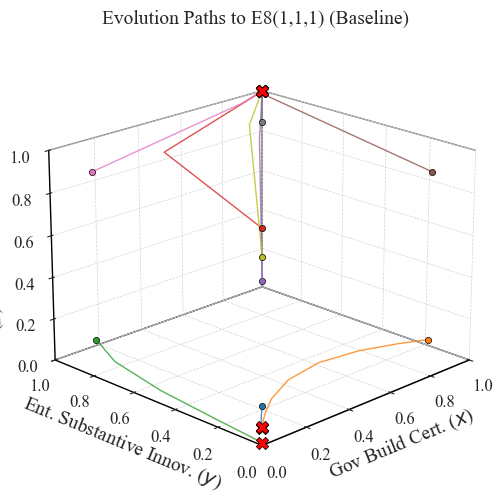

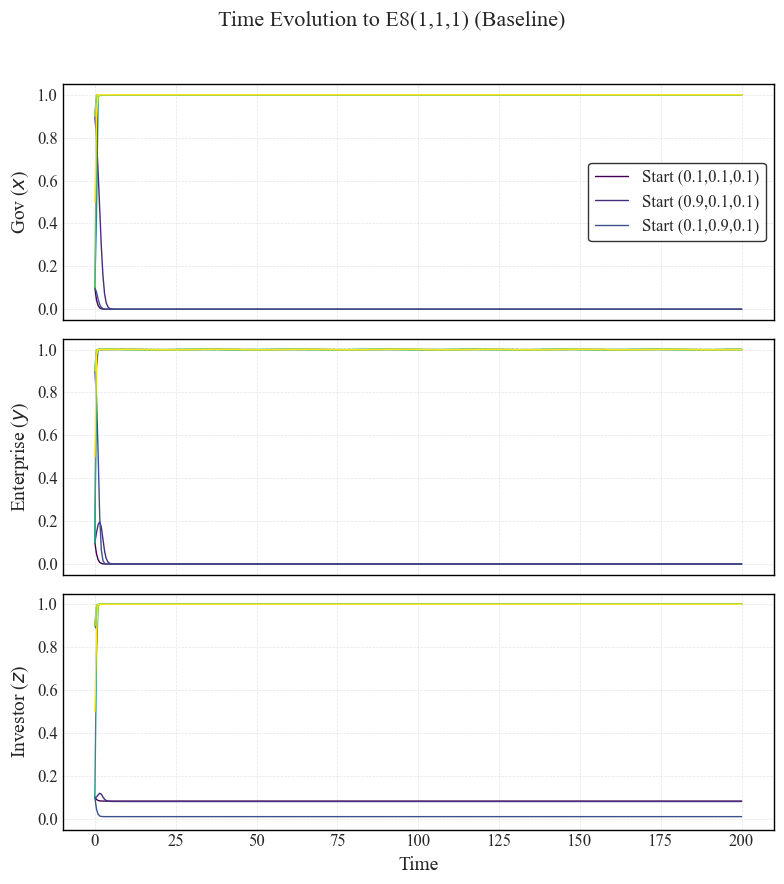


Simulating Figure 2: Pessimistic Scenario (E1 stable)


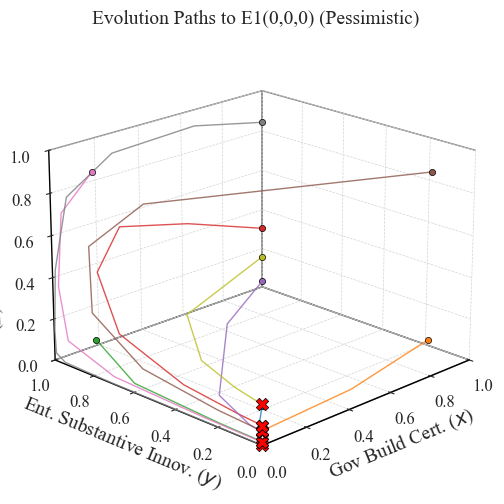

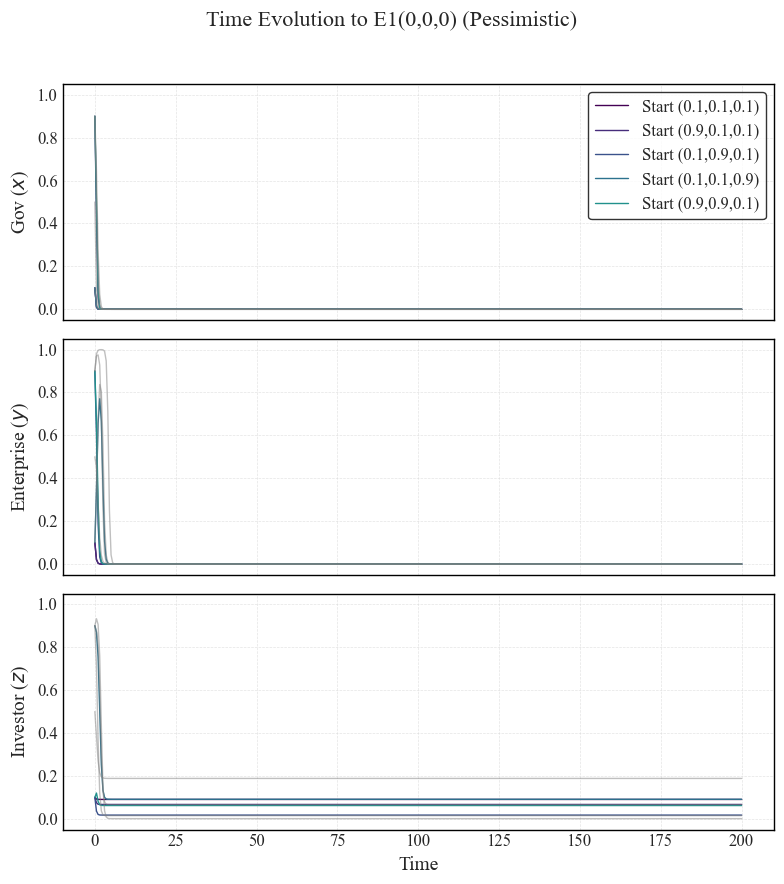


Simulating Figure 3: Single Parameter Sensitivity (B_E - C_certE)


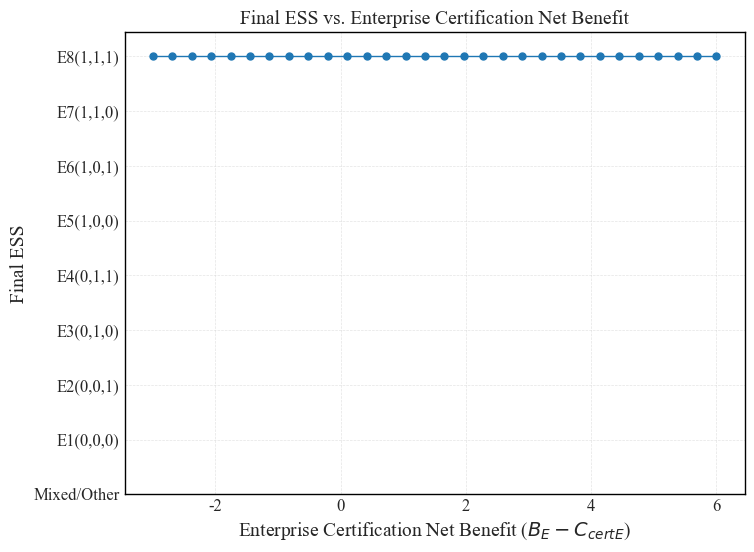


Simulating Figure 3b: Time Evolution for Representative B_E values


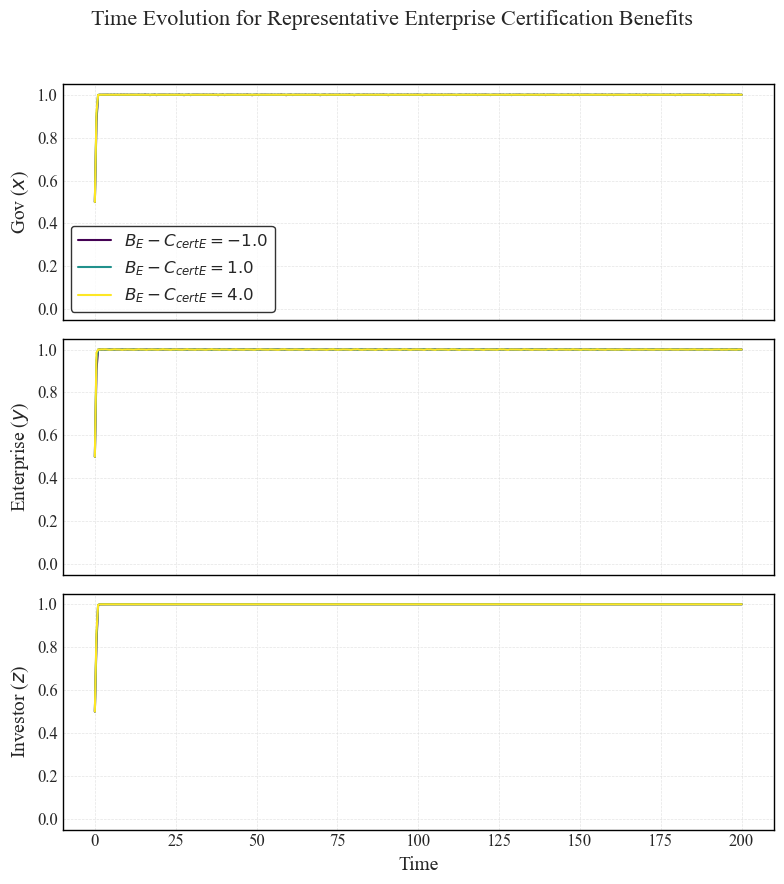


Simulating Figure 4: Single Parameter Sensitivity (Investor Long-term Net Benefit)


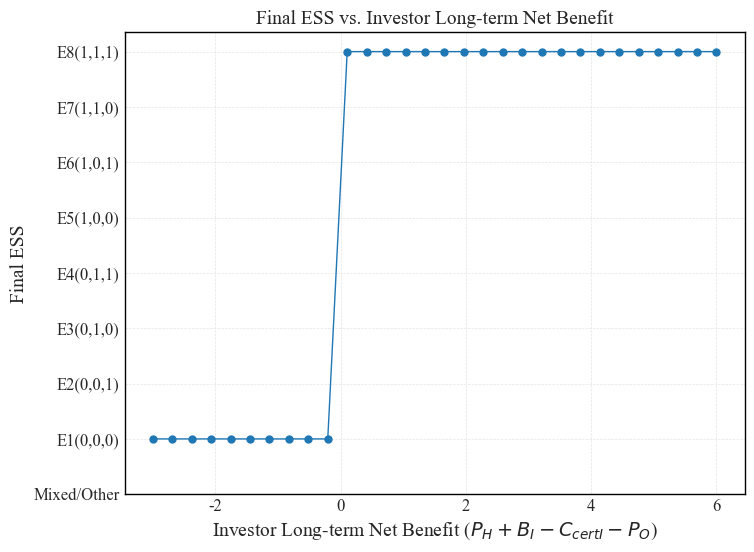


Simulating Figure 4b: Time Evolution for Representative P_H values


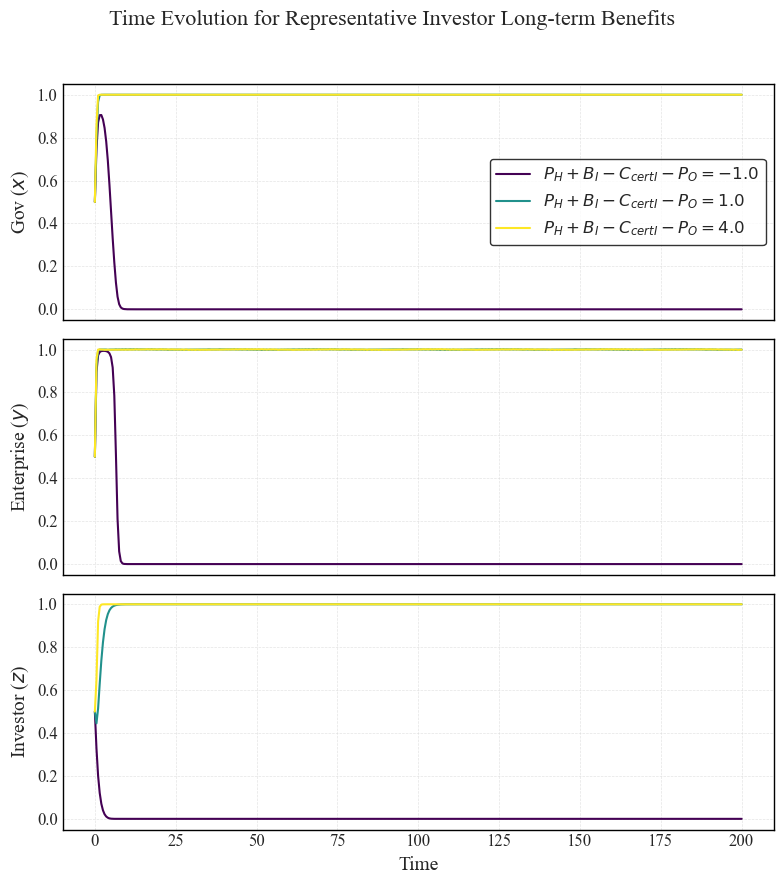


Simulating Figure 5: Two-Parameter Interaction (Ent Cert Net Benefit vs Inv LT Net Benefit)
Running grid simulations for Figure 5...
Grid simulation complete.


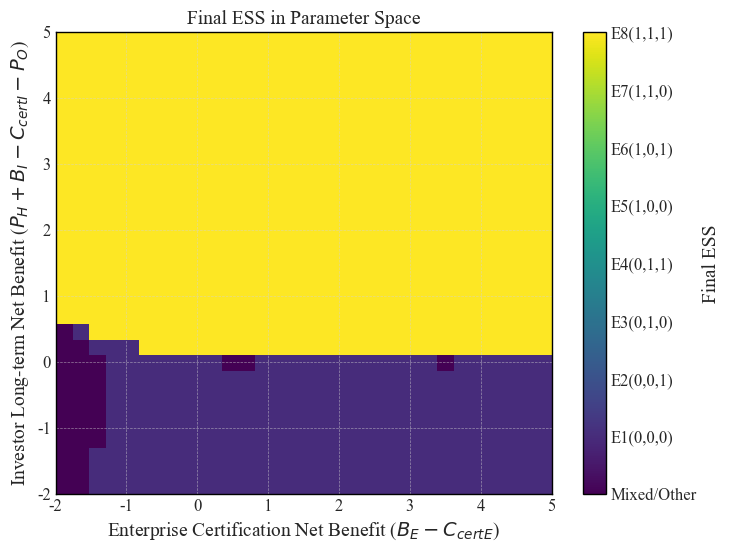


Simulating Figure 6: Basin of Attraction (Potential Bistability)

Simulating 1000 initial conditions for Basin of Attraction...


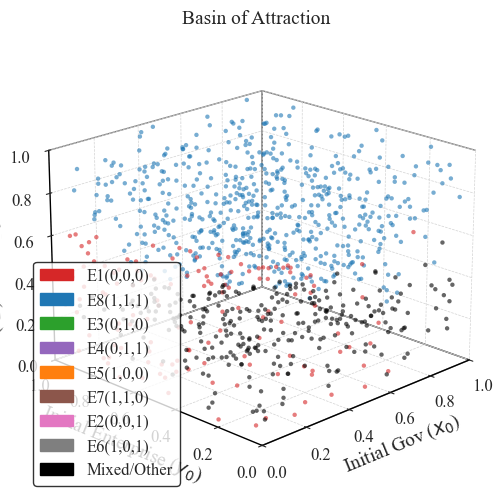


All simulations and plot saving complete. Check the 'simulation_plots' directory.


In [11]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm # 用于颜色映射
import matplotlib.font_manager as fm # 用于设置字体
import os # 用于创建保存目录

# -------------------------------------------
# 设置全局绘图风格，使其更符合学术论文规范
# -------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid') # 使用一个简洁的风格作为基础
# 进一步细调参数
plt.rcParams['font.family'] = 'serif' # 使用衬线字体，更学术
plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'Computer Modern Roman'] # 优先使用Times New Roman
plt.rcParams['font.size'] = 12 # 基础字体大小
plt.rcParams['axes.labelsize'] = 14 # 坐标轴标签大小
plt.rcParams['axes.titlesize'] = 14 # 图标题大小
plt.rcParams['xtick.labelsize'] = 12 # x轴刻度标签大小
plt.rcParams['ytick.labelsize'] = 12 # y轴刻度标签大小
plt.rcParams['legend.fontsize'] = 12 # 图例字体大小
plt.rcParams['figure.titlesize'] = 16 # Figure 标题大小
plt.rcParams['lines.linewidth'] = 1.5 # 线条宽度
plt.rcParams['lines.markersize'] = 6 # 标记大小
plt.rcParams['grid.color'] = 'lightgray' # 网格线颜色
plt.rcParams['grid.linestyle'] = '--' # 网格线样式
plt.rcParams['grid.linewidth'] = 0.5 # 网格线宽度
plt.rcParams['axes.edgecolor'] = 'black' # 坐标轴边框颜色
plt.rcParams['axes.linewidth'] = 1.0 # 坐标轴边框宽度

# 确保中文字体可用，避免乱码 (如果你的系统没有Times New Roman或需要中文标签)
# 检查系统中是否有支持中文的衬线字体，例如 SimHei 或 KaiTi
# 如果需要中文，请取消下面两行的注释，并根据你的系统安装的字体进行调整
# plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial'] # 添加黑体等支持中文的无衬线字体
# plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

# 创建保存图表的目录
output_dir = 'simulation_plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# -------------------------------------------
# 1. 定义复制动态方程 (与之前相同)
# -------------------------------------------
def replication_dynamics(t, Y, params):
    x, y, z = Y
    C_G = params['C_G']
    S_G = params['S_G']
    F_E = params['F_E']
    F_I = params['F_I']
    R_H = params['R_H']
    R_L = params['R_L']
    R_O = params['R_O']
    B_E = params['B_E']
    C_certE = params['C_certE']
    P_H = params['P_H']
    P_L = params['P_L']
    P_O = params['P_O']
    B_I = params['B_I']
    C_certI = params['C_certI']

    U_G1_minus_U_G0 = y * z * S_G + y * F_E + z * F_I - C_G
    U_E1_minus_U_E0 = x * (B_E - C_certE) + z * R_H + (1 - z) * R_L - R_O
    U_I1_minus_U_I0 = x * y * (P_H + B_I - P_O) - x * C_certI + (1 - x) * y * (P_L - P_O)

    dx_dt = x * (1 - x) * U_G1_minus_U_G0
    dy_dt = y * (1 - y) * U_E1_minus_U_E0
    dz_dt = z * (1 - z) * U_I1_minus_U_I0

    return [dx_dt, dy_dt, dz_dt]

# -------------------------------------------
# 2. 定义判断收敛到哪个ESS的函数 (与之前相同)
# -------------------------------------------
def identify_ess(final_state, tolerance=0.05):
    """
    根据最终状态判断收敛到哪个纯策略ESS。
    tolerance: 判断是否接近0或1的容差。
    """
    x, y, z = final_state
    # 纯策略ESS点: (0,0,0), (0,0,1), (0,1,0), (0,1,1), (1,0,0), (1,0,1), (1,1,0), (1,1,1)
    ess_points = {
        (0,0,0): 'E1(0,0,0)', (0,0,1): 'E2(0,0,1)',
        (0,1,0): 'E3(0,1,0)', (0,1,1): 'E4(0,1,1)',
        (1,0,0): 'E5(1,0,0)', (1,0,1): 'E6(1,0,1)',
        (1,1,0): 'E7(1,1,0)', (1,1,1): 'E8(1,1,1)'
    }

    for ess_coords, ess_name in ess_points.items():
        if np.all(np.abs(np.array(final_state) - np.array(ess_coords)) < tolerance):
            return ess_name

    # 如果不收敛到纯策略ESS，可能是混合策略ESS或周期解等
    return 'Mixed/Other'

# -------------------------------------------
# 3. 设置通用仿真参数 (与之前相同)
# -------------------------------------------
t_span = [0, 200] # 延长仿真时间，确保收敛
t_eval = np.linspace(t_span[0], t_span[1], 400) # 更多评估点
# 单个初始点，用于参数敏感性分析，通常选 (0.5, 0.5, 0.5) 代表中性起点
initial_condition_single = [0.5, 0.5, 0.5]
# 多个初始点，用于基准情景和吸引域分析
initial_conditions_multiple = [
    [0.1, 0.1, 0.1], [0.9, 0.1, 0.1], [0.1, 0.9, 0.1], [0.1, 0.1, 0.9],
    [0.9, 0.9, 0.1], [0.9, 0.1, 0.9], [0.1, 0.9, 0.9], [0.9, 0.9, 0.9],
    [0.5, 0.5, 0.5]
]

# -------------------------------------------
# 4. 定义基准参数 (需要根据你的实际研究和理论分析设定)
#    设定一组参数，使得 E8(1,1,1) 在理论上是稳定的
# -------------------------------------------
base_params = {
    'C_G': 2, 'S_G': 10, 'F_E': 1, 'F_I': 1,  # S_G + F_E + F_I - C_G = 10 > 0
    'R_H': 15, 'R_L': 2, 'R_O': 5, 'B_E': 4, 'C_certE': 1, # B_E - C_certE + R_H - R_O = 3 + 15 - 5 = 13 > 0
    'P_H': 12, 'P_L': 3, 'P_O': 6, 'B_I': 3, 'C_certI': 1   # P_H + B_I - C_certI - P_O = 12 + 3 - 1 - 6 = 8 > 0
}

# -------------------------------------------
# 5. 仿真场景实现
# -------------------------------------------

# --- 图 1：基准情景演化图 (验证 E8 稳定) ---
print("Simulating Figure 1: Baseline Scenario (E8 stable)")
results_fig1 = []
for ic in initial_conditions_multiple:
    sol = solve_ivp(replication_dynamics, t_span, ic, args=(base_params,), dense_output=True, t_eval=t_eval, method='RK45')
    results_fig1.append(sol)

# 绘制 3D 相图
fig1a = plt.figure(figsize=(8, 6)) # 调整图尺寸
ax1a = fig1a.add_subplot(111, projection='3d')
for res in results_fig1:
    ax1a.plot(res.y[0], res.y[1], res.y[2], lw=1.0, alpha=0.8) # 调整线宽和透明度
    ax1a.scatter(res.y[0][0], res.y[1][0], res.y[2][0], marker='o', s=20, edgecolors='k', linewidths=0.5) # 调整标记大小和样式
    ax1a.scatter(res.y[0][-1], res.y[1][-1], res.y[2][-1], marker='X', s=80, c='red', edgecolors='k', linewidths=0.5) # 结束点使用不同标记和颜色

ax1a.set_xlabel('Gov Build Cert. ($x$)') # 增加变量符号
ax1a.set_ylabel('Ent. Substantive Innov. ($y$)')
ax1a.set_zlabel('Inv. Long-term ($z$)')
ax1a.set_title("Evolution Paths to E8(1,1,1) (Baseline)") # 标题可以更简洁
ax1a.set_xlim([0, 1]); ax1a.set_ylim([0, 1]); ax1a.set_zlim([0, 1])
ax1a.xaxis.pane.fill = False # 移除背景填充
ax1a.yaxis.pane.fill = False
ax1a.zaxis.pane.fill = False
ax1a.xaxis.pane.set_edgecolor('k') # 设置边框颜色
ax1a.yaxis.pane.set_edgecolor('k')
ax1a.zaxis.pane.set_edgecolor('k')
ax1a.view_init(elev=20, azim=-135) # 调整视角，使其更清晰

# 保存图表
fig1a.savefig(os.path.join(output_dir, 'Figure1a_E8_evolution_3D.png'), dpi=300, bbox_inches='tight')
fig1a.savefig(os.path.join(output_dir, 'Figure1a_E8_evolution_3D.pdf'), bbox_inches='tight')
plt.show()

# 绘制时间演化图
fig1b, axs1b = plt.subplots(3, 1, figsize=(8, 9), sharex=True) # 调整图尺寸
colors = plt.cm.viridis(np.linspace(0, 1, len(results_fig1))) # 使用颜色映射区分不同初始点

for i, res in enumerate(results_fig1):
    axs1b[0].plot(res.t, res.y[0], color=colors[i], lw=1.0, label=f'Start ({res.y[0][0]:.1f},{res.y[1][0]:.1f},{res.y[2][0]:.1f})' if i < 3 else None) # 只显示部分图例
    axs1b[1].plot(res.t, res.y[1], color=colors[i], lw=1.0)
    axs1b[2].plot(res.t, res.y[2], color=colors[i], lw=1.0)

axs1b[0].set_ylabel('Gov ($x$)')
axs1b[1].set_ylabel('Enterprise ($y$)')
axs1b[2].set_ylabel('Investor ($z$)')
axs1b[2].set_xlabel('Time')

for ax in axs1b:
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_ylim([-0.05, 1.05])
    ax.tick_params(direction='in') # 刻度线朝内

axs1b[0].legend(loc='best', frameon=True, edgecolor='k') # 添加图例边框
fig1b.suptitle("Time Evolution to E8(1,1,1) (Baseline)")
plt.tight_layout(rect=[0, 0, 1, 0.96])

# 保存图表
fig1b.savefig(os.path.join(output_dir, 'Figure1b_E8_time_evolution.png'), dpi=300, bbox_inches='tight')
fig1b.savefig(os.path.join(output_dir, 'Figure1b_E8_time_evolution.pdf'), bbox_inches='tight')
plt.show()


# --- 图 2：悲观情景演化图 (验证 E1 稳定) ---
print("\nSimulating Figure 2: Pessimistic Scenario (E1 stable)")
pessimistic_params = {
    'C_G': 5, 'S_G': 1, 'F_E': 0.5, 'F_I': 0.5,
    'R_H': 10, 'R_L': 2, 'R_O': 6, 'B_E': 1, 'C_certE': 1,
    'P_H': 8, 'P_L': 3, 'P_O': 6, 'B_I': 1, 'C_certI': 1
}

results_fig2 = []
for ic in initial_conditions_multiple:
    sol = solve_ivp(replication_dynamics, t_span, ic, args=(pessimistic_params,), dense_output=True, t_eval=t_eval, method='RK45')
    results_fig2.append(sol)

# 绘制 3D 相图
fig2a = plt.figure(figsize=(8, 6))
ax2a = fig2a.add_subplot(111, projection='3d')
for res in results_fig2:
    ax2a.plot(res.y[0], res.y[1], res.y[2], lw=1.0, alpha=0.8)
    ax2a.scatter(res.y[0][0], res.y[1][0], res.y[2][0], marker='o', s=20, edgecolors='k', linewidths=0.5)
    ax2a.scatter(res.y[0][-1], res.y[1][-1], res.y[2][-1], marker='X', s=80, c='red', edgecolors='k', linewidths=0.5)

ax2a.set_xlabel('Gov Build Cert. ($x$)')
ax2a.set_ylabel('Ent. Substantive Innov. ($y$)')
ax2a.set_zlabel('Inv. Long-term ($z$)')
ax2a.set_title("Evolution Paths to E1(0,0,0) (Pessimistic)")
ax2a.set_xlim([0, 1]); ax2a.set_ylim([0, 1]); ax2a.set_zlim([0, 1])
ax2a.xaxis.pane.fill = False
ax2a.yaxis.pane.fill = False
ax2a.zaxis.pane.fill = False
ax2a.xaxis.pane.set_edgecolor('k')
ax2a.yaxis.pane.set_edgecolor('k')
ax2a.zaxis.pane.set_edgecolor('k')
ax2a.view_init(elev=20, azim=-135)

# 保存图表
fig2a.savefig(os.path.join(output_dir, 'Figure2a_E1_evolution_3D.png'), dpi=300, bbox_inches='tight')
fig2a.savefig(os.path.join(output_dir, 'Figure2a_E1_evolution_3D.pdf'), bbox_inches='tight')
plt.show()

# 绘制时间演化图
fig2b, axs2b = plt.subplots(3, 1, figsize=(8, 9), sharex=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(results_fig2)))

for i, res in enumerate(results_fig2):
    if i < 5:
        axs2b[0].plot(res.t, res.y[0], color=colors[i], lw=1.0, label=f'Start ({res.y[0][0]:.1f},{res.y[1][0]:.1f},{res.y[2][0]:.1f})')
        axs2b[1].plot(res.t, res.y[1], color=colors[i], lw=1.0)
        axs2b[2].plot(res.t, res.y[2], color=colors[i], lw=1.0)
    else:
        axs2b[0].plot(res.t, res.y[0], color='gray', alpha=0.5, lw=1.0)
        axs2b[1].plot(res.t, res.y[1], color='gray', alpha=0.5, lw=1.0)
        axs2b[2].plot(res.t, res.y[2], color='gray', alpha=0.5, lw=1.0)

axs2b[0].set_ylabel('Gov ($x$)')
axs2b[1].set_ylabel('Enterprise ($y$)')
axs2b[2].set_ylabel('Investor ($z$)')
axs2b[2].set_xlabel('Time')

for ax in axs2b:
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_ylim([-0.05, 1.05])
    ax.tick_params(direction='in')

axs2b[0].legend(loc='best', frameon=True, edgecolor='k')
fig2b.suptitle("Time Evolution to E1(0,0,0) (Pessimistic)")
plt.tight_layout(rect=[0, 0, 1, 0.96])

# 保存图表
fig2b.savefig(os.path.join(output_dir, 'Figure2b_E1_time_evolution.png'), dpi=300, bbox_inches='tight')
fig2b.savefig(os.path.join(output_dir, 'Figure2b_E1_time_evolution.pdf'), bbox_inches='tight')
plt.show()


# --- 图 3：单参数敏感性分析 (例如：企业认证净收益 B_E - C_certE) ---
print("\nSimulating Figure 3: Single Parameter Sensitivity (B_E - C_certE)")
c_cert_e_fixed = base_params['C_certE']
b_e_values = np.linspace(c_cert_e_fixed - 3, c_cert_e_fixed + 6, 30) # 增加点数使曲线更平滑
enterprise_cert_net_benefits = b_e_values - c_cert_e_fixed

final_ess_fig3 = []
for b_e_val in b_e_values:
    current_params = base_params.copy()
    current_params['B_E'] = b_e_val
    sol = solve_ivp(replication_dynamics, t_span, initial_condition_single, args=(current_params,), dense_output=True, t_eval=t_eval, method='RK45')
    final_ess_fig3.append(identify_ess(sol.y[:, -1]))

ess_mapping = {'E1(0,0,0)': 1, 'E2(0,0,1)': 2, 'E3(0,1,0)': 3, 'E4(0,1,1)': 4,
               'E5(1,0,0)': 5, 'E6(1,0,1)': 6, 'E7(1,1,0)': 7, 'E8(1,1,1)': 8,
               'Mixed/Other': 0}
ess_numeric_fig3 = [ess_mapping[ess] for ess in final_ess_fig3]

fig3a = plt.figure(figsize=(8, 6))
plt.plot(enterprise_cert_net_benefits, ess_numeric_fig3, 'o-', markersize=5, lw=1.0) # 调整标记和线宽
plt.yticks(list(ess_mapping.values()), list(ess_mapping.keys()))
plt.xlabel('Enterprise Certification Net Benefit ($B_E - C_{certE}$)')
plt.ylabel('Final ESS')
plt.title('Final ESS vs. Enterprise Certification Net Benefit')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tick_params(direction='in')

# 保存图表
fig3a.savefig(os.path.join(output_dir, 'Figure3a_BE_sensitivity.png'), dpi=300, bbox_inches='tight')
fig3a.savefig(os.path.join(output_dir, 'Figure3a_BE_sensitivity.pdf'), bbox_inches='tight')
plt.show()

# 图 3b: 选取几个代表性的 B_E 值绘制时间演化图
print("\nSimulating Figure 3b: Time Evolution for Representative B_E values")
# 例如：净收益为 -1, 1, 4
representative_be_net_benefits = [-1, 1, 4]
representative_be_values = [nb + c_cert_e_fixed for nb in representative_be_net_benefits]

results_fig3b = {}
for b_e_val in representative_be_values:
    current_params = base_params.copy()
    current_params['B_E'] = b_e_val
    sol = solve_ivp(replication_dynamics, t_span, initial_condition_single, args=(current_params,), dense_output=True, t_eval=t_eval, method='RK45')
    results_fig3b[f'$B_E - C_{{certE}} = {b_e_val-c_cert_e_fixed:.1f}$'] = sol # 使用LaTeX格式标签

fig3b, axs3b = plt.subplots(3, 1, figsize=(8, 9), sharex=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(results_fig3b)))
for i, (label, res) in enumerate(results_fig3b.items()):
    axs3b[0].plot(res.t, res.y[0], color=colors[i], lw=1.5, label=label)
    axs3b[1].plot(res.t, res.y[1], color=colors[i], lw=1.5)
    axs3b[2].plot(res.t, res.y[2], color=colors[i], lw=1.5)

axs3b[0].set_ylabel('Gov ($x$)')
axs3b[1].set_ylabel('Enterprise ($y$)')
axs3b[2].set_ylabel('Investor ($z$)')
axs3b[2].set_xlabel('Time')

for ax in axs3b:
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_ylim([-0.05, 1.05])
    ax.tick_params(direction='in')

axs3b[0].legend(loc='best', frameon=True, edgecolor='k')
fig3b.suptitle("Time Evolution for Representative Enterprise Certification Benefits")
plt.tight_layout(rect=[0, 0, 1, 0.96])

# 保存图表
fig3b.savefig(os.path.join(output_dir, 'Figure3b_BE_time_evolution.png'), dpi=300, bbox_inches='tight')
fig3b.savefig(os.path.join(output_dir, 'Figure3b_BE_time_evolution.pdf'), bbox_inches='tight')
plt.show()


# --- 图 4：单参数敏感性分析 (例如：投资机构长期投资净收益 P_H + B_I - C_certI - P_O) ---
print("\nSimulating Figure 4: Single Parameter Sensitivity (Investor Long-term Net Benefit)")
b_i_fixed = base_params['B_I']
c_certi_fixed = base_params['C_certI']
p_o_fixed = base_params['P_O']
p_h_values = np.linspace(p_o_fixed + c_certi_fixed - b_i_fixed - 3, p_o_fixed + c_certi_fixed - b_i_fixed + 6, 30)
investor_lt_net_benefits = p_h_values + b_i_fixed - c_certi_fixed - p_o_fixed

final_ess_fig4 = []
for p_h_val in p_h_values:
    current_params = base_params.copy()
    current_params['P_H'] = p_h_val
    sol = solve_ivp(replication_dynamics, t_span, initial_condition_single, args=(current_params,), dense_output=True, t_eval=t_eval, method='RK45')
    final_ess_fig4.append(identify_ess(sol.y[:, -1]))

ess_numeric_fig4 = [ess_mapping[ess] for ess in final_ess_fig4]

fig4a = plt.figure(figsize=(8, 6))
plt.plot(investor_lt_net_benefits, ess_numeric_fig4, 'o-', markersize=5, lw=1.0)
plt.yticks(list(ess_mapping.values()), list(ess_mapping.keys()))
plt.xlabel('Investor Long-term Net Benefit ($P_H + B_I - C_{certI} - P_O$)')
plt.ylabel('Final ESS')
plt.title('Final ESS vs. Investor Long-term Net Benefit')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tick_params(direction='in')

# 保存图表
fig4a.savefig(os.path.join(output_dir, 'Figure4a_InvLT_sensitivity.png'), dpi=300, bbox_inches='tight')
fig4a.savefig(os.path.join(output_dir, 'Figure4a_InvLT_sensitivity.pdf'), bbox_inches='tight')
plt.show()

# 图 4b: 选取几个代表性的 P_H 值绘制时间演化图
print("\nSimulating Figure 4b: Time Evolution for Representative P_H values")
representative_ph_net_benefits = [-1, 1, 4]
representative_ph_values = [nb + p_o_fixed + c_certi_fixed - b_i_fixed for nb in representative_ph_net_benefits]

results_fig4b = {}
for p_h_val in representative_ph_values:
    current_params = base_params.copy()
    current_params['P_H'] = p_h_val
    sol = solve_ivp(replication_dynamics, t_span, initial_condition_single, args=(current_params,), dense_output=True, t_eval=t_eval, method='RK45')
    results_fig4b[f'$P_H + B_I - C_{{certI}} - P_O = {p_h_val+b_i_fixed-c_certi_fixed-p_o_fixed:.1f}$'] = sol # 使用LaTeX格式标签

fig4b, axs4b = plt.subplots(3, 1, figsize=(8, 9), sharex=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(results_fig4b)))
for i, (label, res) in enumerate(results_fig4b.items()):
    axs4b[0].plot(res.t, res.y[0], color=colors[i], lw=1.5, label=label)
    axs4b[1].plot(res.t, res.y[1], color=colors[i], lw=1.5)
    axs4b[2].plot(res.t, res.y[2], color=colors[i], lw=1.5)

axs4b[0].set_ylabel('Gov ($x$)')
axs4b[1].set_ylabel('Enterprise ($y$)')
axs4b[2].set_ylabel('Investor ($z$)')
axs4b[2].set_xlabel('Time')

for ax in axs4b:
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_ylim([-0.05, 1.05])
    ax.tick_params(direction='in')

axs4b[0].legend(loc='best', frameon=True, edgecolor='k')
fig4b.suptitle("Time Evolution for Representative Investor Long-term Benefits")
plt.tight_layout(rect=[0, 0, 1, 0.96])

# 保存图表
fig4b.savefig(os.path.join(output_dir, 'Figure4b_InvLT_time_evolution.png'), dpi=300, bbox_inches='tight')
fig4b.savefig(os.path.join(output_dir, 'Figure4b_InvLT_time_evolution.pdf'), bbox_inches='tight')
plt.show()


# --- 图 5：双参数交互影响分析 (企业认证净收益 vs. 机构长期投资净收益) ---
print("\nSimulating Figure 5: Two-Parameter Interaction (Ent Cert Net Benefit vs Inv LT Net Benefit)")
be_net_range = np.linspace(-2, 5, 30) # 增加点数
inv_lt_net_range = np.linspace(-2, 5, 30) # 增加点数

BE_NET, INV_LT_NET = np.meshgrid(be_net_range, inv_lt_net_range)
final_ess_grid = np.zeros(BE_NET.shape)

print("Running grid simulations for Figure 5...")
for i in range(BE_NET.shape[0]):
    for j in range(BE_NET.shape[1]):
        current_be_net = BE_NET[i, j]
        current_inv_lt_net = INV_LT_NET[i, j]

        current_params = base_params.copy()
        current_params['B_E'] = current_be_net + current_params['C_certE']
        current_params['P_H'] = current_inv_lt_net + current_params['P_O'] + current_params['C_certI'] - current_params['B_I']

        sol = solve_ivp(replication_dynamics, t_span, initial_condition_single, args=(current_params,), dense_output=True, t_eval=t_eval, method='RK45')
        final_ess_grid[i, j] = ess_mapping.get(identify_ess(sol.y[:, -1]), 0)

print("Grid simulation complete.")

fig5 = plt.figure(figsize=(8, 6))
# 使用更专业的颜色映射，如 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
# 确保颜色条的刻度和标签清晰
im = plt.imshow(final_ess_grid, origin='lower', extent=[be_net_range.min(), be_net_range.max(), inv_lt_net_range.min(), inv_lt_net_range.max()],
           aspect='auto', cmap='viridis', interpolation='nearest')

cbar = plt.colorbar(im)
cbar.set_ticks(list(ess_mapping.values()))
cbar.set_ticklabels(list(ess_mapping.keys()))
cbar.set_label('Final ESS')

plt.xlabel('Enterprise Certification Net Benefit ($B_E - C_{certE}$)')
plt.ylabel('Investor Long-term Net Benefit ($P_H + B_I - C_{certI} - P_O$)')
plt.title('Final ESS in Parameter Space')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tick_params(direction='in')

# 保存图表
fig5.savefig(os.path.join(output_dir, 'Figure5_TwoParam_Interaction.png'), dpi=300, bbox_inches='tight')
fig5.savefig(os.path.join(output_dir, 'Figure5_TwoParam_Interaction.pdf'), bbox_inches='tight')
plt.show()


# --- 图 6：双稳态情景下的吸引域图 ---
print("\nSimulating Figure 6: Basin of Attraction (Potential Bistability)")
# 设定一组参数，使得 E1(0,0,0) 和 E8(1,1,1) 都可能是ESS
# 这组参数需要根据你的理论分析和尝试来确定
bistable_params = {
    'C_G': 4, 'S_G': 6, 'F_E': 1, 'F_I': 1,
    'R_H': 10, 'R_L': 3, 'R_O': 5, 'B_E': 2, 'C_certE': 1,
    'P_H': 8, 'P_L': 4, 'P_O': 5, 'B_I': 2, 'C_certI': 1
}

num_initial_points = 1000 # 增加点数以更清晰地描绘吸引域
initial_conditions_basin = np.random.rand(num_initial_points, 3)

final_states_basin = []
ess_labels_basin = []

print(f"\nSimulating {num_initial_points} initial conditions for Basin of Attraction...")
for ic in initial_conditions_basin:
    sol = solve_ivp(replication_dynamics, t_span, ic, args=(bistable_params,), dense_output=True, t_eval=t_eval, method='RK45')
    final_state = sol.y[:, -1]
    ess_labels_basin.append(identify_ess(final_state))

# 将ESS标签映射到颜色 (使用更专业的颜色映射或手动指定颜色)
# 可以为每个ESS指定一个独特的颜色
ess_colors_map = {
    'E1(0,0,0)': 'tab:red',      # 红色
    'E8(1,1,1)': 'tab:blue',     # 蓝色
    'E3(0,1,0)': 'tab:green',    # 绿色
    'E4(0,1,1)': 'tab:purple',   # 紫色
    'E5(1,0,0)': 'tab:orange',   # 橙色
    'E7(1,1,0)': 'tab:brown',    # 棕色
    'E2(0,0,1)': 'tab:pink',     # 粉色
    'E6(1,0,1)': 'tab:gray',     # 灰色
    'Mixed/Other': 'black'       # 黑色
}
colors_basin = [ess_colors_map[label] for label in ess_labels_basin]

fig6 = plt.figure(figsize=(8, 6))
ax6 = fig6.add_subplot(111, projection='3d')

# 绘制初始点，用颜色区分收敛到的ESS
scatter = ax6.scatter(initial_conditions_basin[:, 0], initial_conditions_basin[:, 1], initial_conditions_basin[:, 2],
                      c=colors_basin, marker='o', s=10, alpha=0.6, edgecolors='none') # 移除边缘颜色

ax6.set_xlabel('Initial Gov ($x_0$)') # 明确是初始值
ax6.set_ylabel('Initial Enterprise ($y_0$)')
ax6.set_zlabel('Initial Investor ($z_0$)')
ax6.set_title('Basin of Attraction')
ax6.set_xlim([0, 1]); ax6.set_ylim([0, 1]); ax6.set_zlim([0, 1])
ax6.xaxis.pane.fill = False
ax6.yaxis.pane.fill = False
ax6.zaxis.pane.fill = False
ax6.xaxis.pane.set_edgecolor('k')
ax6.yaxis.pane.set_edgecolor('k')
ax6.zaxis.pane.set_edgecolor('k')
ax6.view_init(elev=20, azim=-135)

# 添加图例 (手动创建)
handles = [mpatches.Patch(color=ess_colors_map[label], label=label) for label in ess_colors_map.keys()]
ax6.legend(handles=handles, loc='best', frameon=True, edgecolor='k')

# 保存图表
fig6.savefig(os.path.join(output_dir, 'Figure6_Basin_of_Attraction.png'), dpi=300, bbox_inches='tight')
fig6.savefig(os.path.join(output_dir, 'Figure6_Basin_of_Attraction.pdf'), bbox_inches='tight')
plt.show()

print("\nAll simulations and plot saving complete. Check the 'simulation_plots' directory.")

